# classes and functions

In [1]:
import matplotlib
import matplotlib.pyplot as plt

import sys
import os
import glob
import configparser

import h5py
import numpy as np

import scipy.integrate
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

import phenom

import lmfit
from lmfit import Minimizer, Parameters, report_fit

import pickle

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [2]:
matplotlib.rcParams.update({'font.size': 16})

In [3]:
def compute_integral(times, x, npts=None):
    """
    times = array of independent variable
    x = array of dependent variable
    npts = None (default to len(times)) number o fpoints to resample to integrate
    """
    
    if npts is None:
        npts = len(times)*2

    ix = IUS(times,  x)

    t1 = times[0]
    t2 = times[-1]
    res = []
    dt = times[1] - times[0]
    tss = np.linspace(t1+dt, t2, 1000)
    for ts in tss: 
        res.append(scipy.integrate.quad(ix, t1, ts)[0])
    res = np.array(res)

    ires = IUS(tss, res)
    return ires(times)

In [4]:
def match(h1, h2, times):
        
    dt = times[1] - times[0]
    n = len(times)
    df = 1.0/(n*dt)
    norm = 4. * df
    
    h1_fft = np.fft.fft(h1)
    h2_fft = np.fft.fft(h2)
    
    h1h1_sq = np.vdot(h1_fft, h1_fft) * norm
    h2h2_sq = np.vdot(h2_fft, h2_fft) * norm
    
    h1h1 = dt * np.sqrt(h1h1_sq)
    h2h2 = dt * np.sqrt(h2h2_sq)
    

    ifft = np.fft.ifft(np.conj(h1_fft) * h2_fft)
    
    return ifft / h1h1 / h2h2 * 4 * dt

In [5]:
def planck_taper(times, t1, t2):
    """times: array of times
    t1. for t<=t1 then return 0
    t2. for t>=t2 then return 1
    else return 1./(np.exp((t2-t1)/(t-t1)+(t2-t1)/(t-t2))+1)"""
    tout = []
    for t in times:
        if t<=t1:
            tout.append(0.)
        elif t>=t2:
            tout.append(1.)
        else:
            tout.append(1./(np.exp((t2-t1)/(t-t1)+(t2-t1)/(t-t2))+1))
    return np.array(tout)

In [6]:
# Newton gravity constant
# lal.G_SI: 6.67384e-11
G_Newt = 6.67384e-11

In [7]:
# light speed
# lal.C_SI: 299792458.0
c_ls = 299792458.0

In [8]:
# lal.MSUN_SI: 1.9885469549614615e+30
MSUN_SI = 1.9885469549614615e+30

In [9]:
MTSUN_SI = 4.925491025543576e-06

In [10]:
# lal.MRSUN_SI: 1476.6250614046494
MRSUN_SI = 1476.6250614046494

In [11]:
# lal.PC_SI: 3.085677581491367e+16
PC_SI = 3.085677581491367e+16

In [12]:
# lal.GAMMA: 0.5772156649015329
GAMMA = 0.5772156649015329

In [13]:
def Msun_to_sec(M):
    """
    convert mass (in units of solar masses)
    into seconds
    """
#     return M *lal.MSUN_SI* G_Newt / c_ls**3.
    return M * MTSUN_SI

In [14]:
def td_amp_scale(mtot, distance):
    """
    mtot in solar masses
    distance in Mpc
    M*G/c^2 * M_sun / dist
    """
    return mtot * MRSUN_SI / (distance * 1e6*PC_SI)

In [15]:
def mass1_from_mtotal_eta(mtotal, eta):
    """Returns the primary mass from the total mass and symmetric mass
    ratio.
    """
    return 0.5 * mtotal * (1.0 + (1.0 - 4.0 * eta)**0.5)


def mass2_from_mtotal_eta(mtotal, eta):
    """Returns the secondary mass from the total mass and symmetric mass
    ratio.
    """
    return 0.5 * mtotal * (1.0 - (1.0 - 4.0 * eta)**0.5)


def eta_from_q(q):
    """
    converts mass-ratio to symmetric mass-ratio
    input: q
    output: eta
    """
    return q/(1.+q)**2

In [16]:
class SingleModeNRWaveform(object):
    def __init__(self, nrfile, ell, mm, npts, t1=None, t2=None):

        self.nrfile = nrfile
        self.npts = npts
        self.t1=t1
        self.t2=t2

        self.get_lm_mode(self.nrfile, ell, mm, self.npts)


    def get_lm_mode(self, nrfile, ell, mm, npts):
        
        if '.h5' in nrfile:
            f = h5py.File(nrfile, 'r')

            self.q = f.attrs['mass1']/f.attrs['mass2']
            self.eta = f.attrs['eta']

            amp_tmp = f['amp_l{0}_m{1}'.format(ell, mm)]
            amp_x = amp_tmp['X'].value
            amp_y = amp_tmp['Y'].value

            phase_tmp = f['phase_l{0}_m{1}'.format(ell, mm)]
            phase_x = phase_tmp['X'].value
            phase_y = phase_tmp['Y'].value

            f.close()
        else:
            # bam
            self.sim_dir = os.path.dirname(nrfile)
            self.bbh_file = glob.glob( os.path.join(self.sim_dir, '*.bbh') )[0]
            # strict=False because of DuplicateSectionError
            config = configparser.ConfigParser(strict=False)

            config.read(self.bbh_file)
            mass1_tmp = float(config['metadata']['mass1'])
            mass2_tmp = float(config['metadata']['mass2'])
            self.initial_sep = float(config['metadata']['initial-separation'])

            if mass1_tmp >= mass2_tmp:
                mass1 = mass1_tmp
                mass2 = mass2_tmp
            else:
                mass1 = mass2_tmp
                mass2 = mass1_tmp


            self.mass1 = mass1
            self.mass2 = mass2
            self.mtot = self.mass1 + self.mass2
            self.q = self.mass1 / self.mass2
            self.eta = self.mass1 * self.mass2 / (self.mtot)**2.
            
            times, re_hlm, im_hlm = np.loadtxt(nrfile, unpack=True)

            # SIGN CONVENTION HERE NOTE SURE WHAT IS CORRECT FOR BAM
            hlm = re_hlm - 1.j * im_hlm
            
            amp_x = times
            amp_y = np.abs(hlm)

            phase_x = times
            phase_y = np.unwrap(np.angle(hlm))
            
            
        # shift so that amp peak is at t=0 - will need to be more careful with HMs
        amp_peak_idx = amp_y.argmax()
        amp_peak_time = amp_x[amp_peak_idx]
        amp_x = amp_x - amp_peak_time
        phase_x = phase_x - amp_peak_time
            

        amp_i = IUS(amp_x, amp_y)
        phase_i = IUS(phase_x, phase_y)

        if self.t1 is None:
            self.t1 = max(amp_x[0], phase_x[0])
        if self.t2 is None:
            self.t2 = min(amp_x[-1], phase_x[-1])
            
        # t1,t2=-600,100

        common_times = np.linspace(self.t1, self.t2, npts)

        amplist = amp_i(common_times)
        phaselist = phase_i(common_times)

        self.times = common_times
        self.amp = amplist
        self.phi = phaselist
        # self.hlm["{0}, {1}".format(ell, mm)] = self.amp * np.exp(-1.j * self.phi)
        self.hlm = self.amp * np.exp(-1.j * self.phi)
        

    def resample_data(self, new_time_array):
        """
        new_time_array : numpy.array

        redefines the amp, phi and hlm attributes to be sampled on
        the new_time_array
        """
        amp_i = IUS(self.times, self.amp)
        phi_i = IUS(self.times, self.phi)

        self.npts = len(new_time_array)
        self.times = new_time_array
        self.amp = amp_i(new_time_array)
        self.phi = phi_i(new_time_array)
        self.hlm = self.amp * np.exp(-1.j * self.phi)


In [17]:
class Psi4(object):
    """
    stores Psi4 data aligned such that the peak of Psi4 is at t=0
    """
    def __init__(self, nrfile, ell, mm, npts_time, t1, t2):
        self.nrfile = nrfile
        self.ell = ell
        self.mm = mm
        self.npts_time = npts_time
        self.t1 = t1
        self.t2 = t2
        
        self.nrdata = SingleModeNRWaveform(self.nrfile, self.ell, self.mm, self.npts_time,t1=self.t1,t2=self.t2)
    
        self.eta = self.nrdata.eta
        self.q = float("{:.2f}".format(self.nrdata.q))
        
        ihlmre = IUS(self.nrdata.times, self.nrdata.hlm.real)
        ihlmim = IUS(self.nrdata.times, self.nrdata.hlm.imag)
        
        self.hlm_phase = np.unwrap(np.angle(self.nrdata.hlm))
        i_hlm_phase = IUS(self.nrdata.times, self.hlm_phase)
        self.hlm_ang_freq = i_hlm_phase.derivative()(self.nrdata.times)
        self.hlm_amp = np.abs(self.nrdata.hlm)
        
        # index of maximum
        max_idx_hlm = self.hlm_amp.argmax()
        # time of maximum
        self.time_at_max_idx_hlm = self.nrdata.times[max_idx_hlm]
        
        self.times_hlm = self.nrdata.times - self.time_at_max_idx_hlm
        

        # news
        newslmre = ihlmre.derivative()(self.times_hlm)
        newslmim = ihlmim.derivative()(self.times_hlm)

        self.newslm = newslmre - 1.j*newslmim
        
        self.newslm_amp = np.abs(self.newslm)
        
        # index of maximum
        max_idx_news = self.newslm_amp.argmax()
        # time of maximum
        self.time_at_max_idx_news = self.nrdata.times[max_idx_news]
        
        self.times_news = self.nrdata.times - self.time_at_max_idx_news
        
        self.newslm_phase = np.unwrap(np.angle(self.newslm))
        i_newslm_phase = IUS(self.times_news, self.newslm_phase)
        self.newslm_ang_freq = i_newslm_phase.derivative()(self.times_news)
        
        
        
        # psi4
        psi4lmre = ihlmre.derivative().derivative()(self.nrdata.times)
        psi4lmim = ihlmim.derivative().derivative()(self.nrdata.times)

        self.psi4lm = psi4lmre - 1.j*psi4lmim
        
        self.psi4lm_amp = np.abs(self.psi4lm)
        
        # index of maximum
        max_idx = self.psi4lm_amp.argmax()
        # time of maximum
        self.time_at_max_idx = self.nrdata.times[max_idx]
        
        self.times = self.nrdata.times - self.time_at_max_idx
        
        
        
        self.psi4lm_phase = np.unwrap(np.angle(self.psi4lm))
        i_psi4lm_phase = IUS(self.times, self.psi4lm_phase)
        self.psi4lm_ang_freq = i_psi4lm_phase.derivative()(self.times)
        
        

        eta, chi1z, chi2z = self.eta, 0., 0.
        self.fin_spin = phenom.remnant.FinalSpin0815(eta, chi1z, chi2z)
        self.fring = phenom.remnant.fring(eta, chi1z, chi2z, self.fin_spin)
        self.fdamp = phenom.remnant.fdamp(eta, chi1z, chi2z, self.fin_spin)
        self.final_mass = 1.0 - phenom.EradRational0815(eta, chi1z, chi2z)
        
#         self.ang_f_22_isco = phenom.HztoMf(f_SchwarzISCO(self.final_mass), self.final_mass)

        m1 = mass1_from_mtotal_eta(1., eta)
        m2 = mass2_from_mtotal_eta(1., eta)
#         self.hyb_meco_ang_freq = phenom.HztoMf(hybrid_meco_frequency(m1, m2, chi1z, chi2z), self.final_mass) * 2 * np.pi

        # get from TaylorT3 orb frequency: https://arxiv.org/abs/0901.2437
#         leading_order = 2
        
    
    
        # time shift between peak of strain and peak of psi4
        # index of maximum
        hlm_max_idx = self.hlm_amp.argmax()
        # time of maximum
        self.hlm_time_at_max_idx = self.nrdata.times[hlm_max_idx]

In [18]:
# # get data
# nrfiles = dict(
#     q1='/Users/spx8sk/work/data/SXS_BBH_0180_Res4.h5',
#     q2='/Users/spx8sk/work/data/SXS_BBH_0169_Res5.h5',
#     q4='/Users/spx8sk/work/data/SXS_BBH_0167_Res5.h5',
#     q5='/Users/spx8sk/work/data/SXS_BBH_0107_Res5.h5',
#     q10='/Users/spx8sk/work/data/SXS_BBH_0303_Res5.h5',
#     q18="/Users/spx8sk/work/data/q18a0a0c025_144/h3col.r7.l5.l2.m2"
# )

In [19]:
# get data
nrfiles = dict(
    q1='/Users/spx8sk/work/data/SXS_BBH_0180_Res4.h5',
    q2='/Users/spx8sk/work/data/SXS_BBH_0169_Res5.h5',
    q4='/Users/spx8sk/work/data/SXS_BBH_0167_Res5.h5',
    q5='/Users/spx8sk/work/data/SXS_BBH_0107_Res5.h5',
    q10='/Users/spx8sk/work/data/SXS_BBH_0303_Res5.h5',
    q18="/Users/spx8sk/work/git/stk/ml/waveforms/bob/q18a0a0c025_144-22-hybrid.h5"
)

In [20]:
ell = 2
mm = 2

npts_time = 1000*6
npts_mass_ratio = len(nrfiles)

# t1=None
# t2=None
# t1=-600
t1=-3100
# t1=-1000
# t1=-800
t2=60


In [21]:
psi4s = {}
for k,v in list(nrfiles.items()):
    psi4s.update({k:Psi4(v, ell, mm, npts_time,t1=t1,t2=t2)})

/Users/spx8sk/anaconda3/envs/wispy-dev/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [22]:
for k in psi4s.keys():
    print("{} = {}".format(k, 1./psi4s[k].fdamp/2/np.pi))

q1 = 11.706422641558191
q2 = 11.554740530290251
q4 = 11.36516841490208
q5 = 11.32930696199893
q10 = 11.272552160962043
q18 = 11.255711435422901


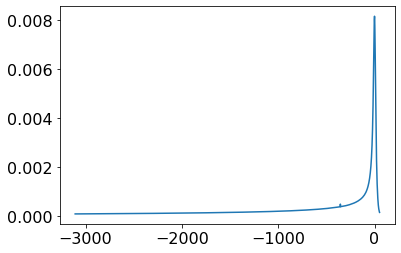

In [23]:
plt.figure()
plt.plot(psi4s['q18'].times, psi4s['q18'].psi4lm_amp)

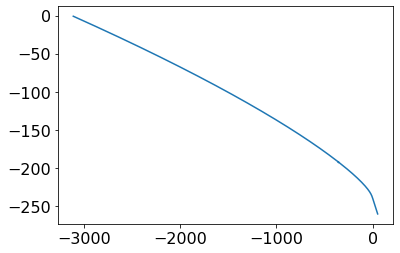

In [24]:
plt.figure()
plt.plot(psi4s['q18'].times, psi4s['q18'].psi4lm_phase)

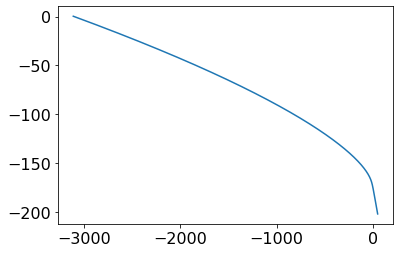

In [25]:
plt.figure()
plt.plot(psi4s['q1'].times, psi4s['q1'].psi4lm_phase)

Text(0.5, 1.0, '$|h|(t)$')

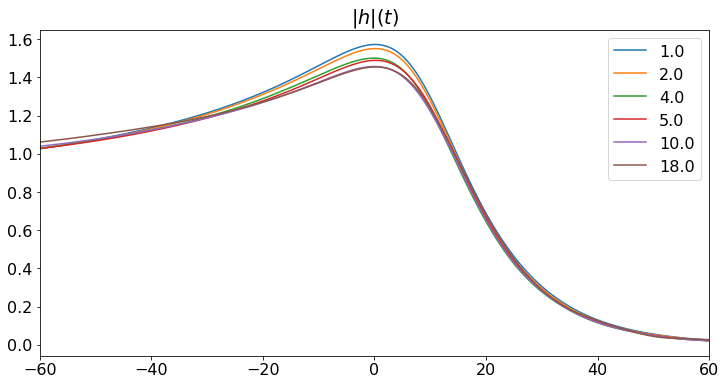

In [26]:
plt.figure(figsize=(12, 6))
for k in psi4s.keys():
    plt.plot(psi4s[k].times_hlm, psi4s[k].hlm_amp / psi4s[k].eta, label=psi4s[k].q)
#     plt.plot(psi4s[k].times, psi4s[k].hlm_amp, label=psi4s[k].q)
plt.legend()
plt.xlim(-60,60)
# plt.ylim(0.2, 1.6)
# plt.yscale('log')
plt.title(r'$|h|(t)$')

Text(0.5, 1.0, '$|N|(t)$')

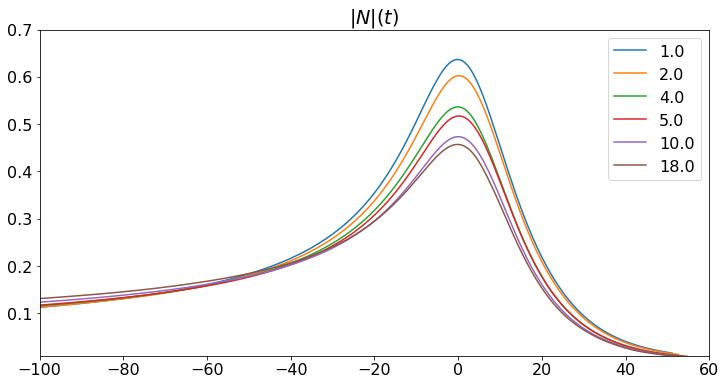

In [27]:
plt.figure(figsize=(12, 6))
for k in psi4s.keys():
    plt.plot(psi4s[k].times_news, psi4s[k].newslm_amp / psi4s[k].eta, label=psi4s[k].q)
    
plt.legend()
plt.xlim(-100,60)
plt.ylim(1e-2, 0.7)
# plt.yscale('log')
plt.title(r'$|N|(t)$')

Text(0.5, 1.0, '$|\\Psi_4|(t)$')

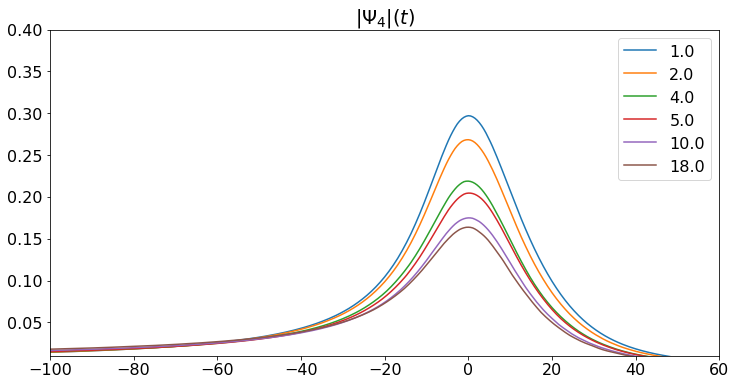

In [28]:
plt.figure(figsize=(12, 6))
for k in psi4s.keys():
    plt.plot(psi4s[k].times, psi4s[k].psi4lm_amp / psi4s[k].eta, label=psi4s[k].q)
    
plt.legend()
plt.xlim(-100,60)
plt.ylim(1e-2, 0.4)
# plt.yscale('log')
plt.title(r'$|\Psi_4|(t)$')

Text(0.5, 1.0, '$\\omega_{gw}(t)$ from $h$')

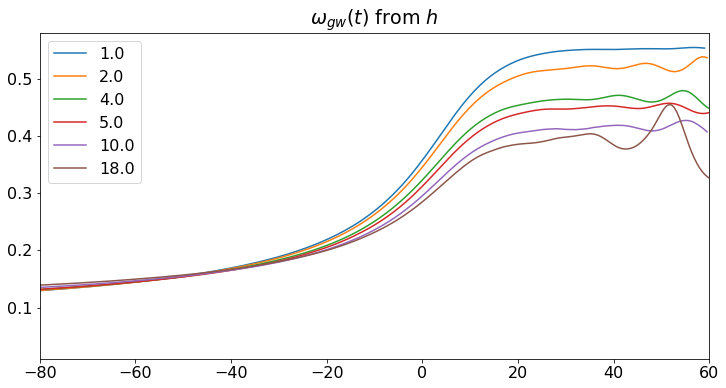

In [29]:
plt.figure(figsize=(12, 6))
for k in psi4s.keys():
    plt.plot(psi4s[k].times_hlm, psi4s[k].hlm_ang_freq, label=psi4s[k].q)
plt.legend()
plt.xlim(-80,60)
# plt.yscale('log')
plt.title(r'$\omega_{gw}(t)$ from $h$')

Text(0.5, 1.0, '$\\omega_{gw}(t)$ from News')

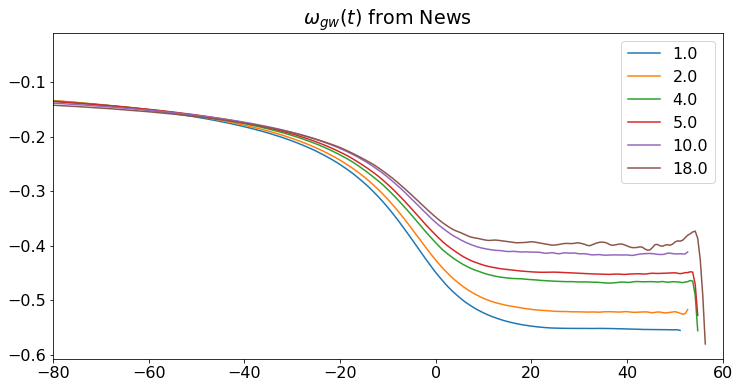

In [30]:
plt.figure(figsize=(12, 6))
for k in psi4s.keys():
    plt.plot(psi4s[k].times_news, psi4s[k].newslm_ang_freq, label=psi4s[k].q)
plt.legend()
plt.xlim(-80,60)
# plt.yscale('log')
plt.title(r'$\omega_{gw}(t)$ from News')

Text(0.5, 1.0, '$\\omega_{gw}(t)$ from $\\Psi_4$')

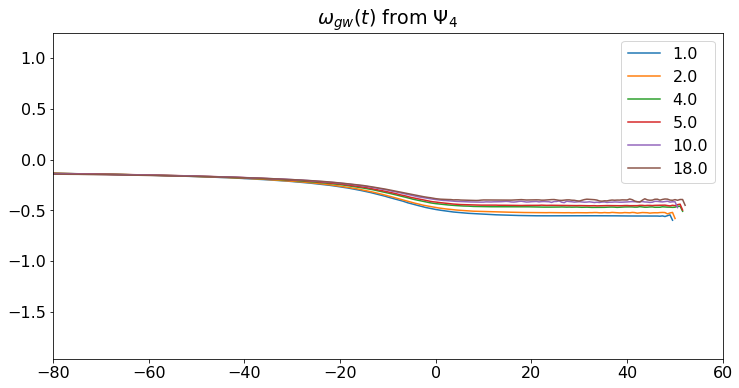

In [31]:
plt.figure(figsize=(12, 6))
for k in psi4s.keys():
    plt.plot(psi4s[k].times, psi4s[k].psi4lm_ang_freq, label=psi4s[k].q)
plt.legend()
plt.xlim(-80,60)
# plt.yscale('log')
plt.title(r'$\omega_{gw}(t)$ from $\Psi_4$')

Text(0.5, 1.0, 'q = 18.0')

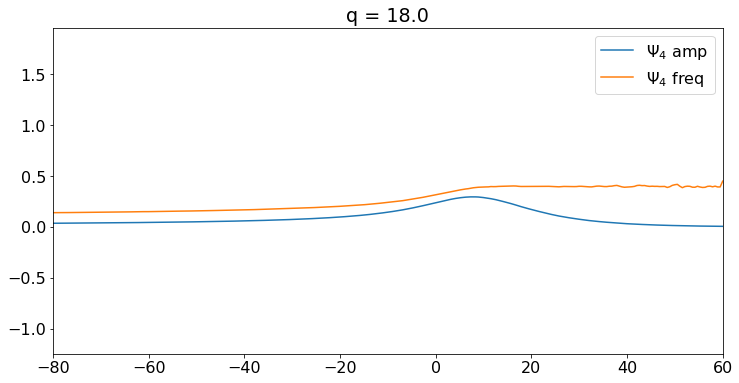

In [36]:
# compare psi4_amp and freq
k = 'q18'

plt.figure(figsize=(12, 6))
plt.plot(psi4s[k].nrdata.times, psi4s[k].psi4lm_amp / psi4s[k].eta * 1.8, label='$\Psi_4$ amp')
plt.plot(psi4s[k].nrdata.times, -psi4s[k].psi4lm_ang_freq, label='$\Psi_4$ freq')
plt.legend()
plt.xlim(-80,60)
# plt.yscale('log')
plt.title(r'q = {}'.format(psi4s[k].q))

# frequency model classes

In [136]:
class Model_Freq_MR(object):
    def __init__(self, Psi4):
        self.Psi4 = Psi4
        
    def ansatz(self, params, t):
        
        t0 = params['t0']
        kappa = params['kappa']
        b = params['b']
        om_f = params['om_f']
        offset = params['offset']
        
#         c = params['c']
#         d = params['d']
#         e = params['e']

        dt = t - t0
        num = 1. + np.tanh((dt/b))
        den = 2.

        model = offset + (om_f - offset) * ((num/den)**(kappa))
        
        return model

    def ansatz_to_min(self, params, t, data):
        model = self.ansatz(params, t)
        return model - data
        
    def fit(self, t1=-10, t2=40):

        self.mask = (self.Psi4.times_hlm > t1) & (self.Psi4.times_hlm < t2)
        self.fit_times = self.Psi4.times_hlm[self.mask]
        self.fit_data = self.Psi4.hlm_ang_freq[self.mask]
        
        # create a set of Parameters
        params = Parameters()
        params.add('t0', value=5., min=-20, max=20)
        params.add('kappa', value=0.44, vary=False)
        params.add('b', value=1./self.Psi4.fdamp/2/np.pi, vary=False)
        params.add('om_f', value=self.Psi4.fring*2*np.pi, vary=False)
        params.add('offset', value=0.175, min=1e-2, max=200, vary=False)
        
#         params.add('c', value=0, min=-200, max=200, vary=False)
#         params.add('d', value=0, min=-200, max=200, vary=False)
#         params.add('e', value=0, min=-200, max=200, vary=False)
        
        fcn2min = self.ansatz_to_min
        minner = Minimizer(fcn2min, params, fcn_args=(self.fit_times, self.fit_data))
        
        self.result = minner.minimize()

        # calculate final result
        self.freq_mr_final = self.fit_data + self.result.residual

        # write error report
        report_fit(self.result)
        
        
    def plot_result(self):

        fit_times = self.fit_times
        fit_data = self.fit_data
        fit_result = self.ansatz(self.result.params,self.fit_times)

        fig, axes = plt.subplots(1, 2, figsize=(14, 6))

        axes[0].plot(fit_times, fit_data, label='data')
        axes[0].plot(fit_times, fit_result, ls='--', label='fit result')
        
        axes[1].plot(fit_times, (fit_data-fit_result)/fit_data * 100)
        
        
        axes[0].legend()
        axes[0].set_title("fit result")
        axes[1].set_title("% error")
        
        fig.text(0.5, 0.04, 't/M', ha='center')

        
        plt.show()
        plt.close()

In [169]:
class Model_Freq_MR_bob(object):
    def __init__(self, Psi4):
        self.Psi4 = Psi4
        
    def ansatz(self, params, t):
        
        t0 = params['t0']
        kappa = params['kappa']
        b = params['b']
        om_f = params['om_f']
        offset = params['offset']
        
        tp = params['tp']
        
#         c = params['c']
#         d = params['d']
#         e = params['e']

        dt = t - tp
    
        dt0tp = t0 - tp
        
        k = (om_f**4 - offset**4) / (1 - np.tanh(dt0tp/b))

        model = (offset**4 + k * (np.tanh(dt/b) - np.tanh(dt0tp/b)) )**(kappa)
        
        return model

    def ansatz_to_min(self, params, t, data):
        model = self.ansatz(params, t)
        return model - data
        
    def fit(self, t1=-10, t2=40):

        self.mask = (self.Psi4.times_hlm > t1) & (self.Psi4.times_hlm < t2)
        self.fit_times = self.Psi4.times_hlm[self.mask]
        self.fit_data = self.Psi4.hlm_ang_freq[self.mask]
        
        # create a set of Parameters
        params = Parameters()
        params.add('t0', value=-10, min=-20, max=-9, vary=False)
        params.add('tp', value=10., min=-10, max=50, vary=True)
        params.add('kappa', value=0.25, vary=False)
        params.add('b', value=1./self.Psi4.fdamp/2/np.pi, vary=False)
        params.add('om_f', value=self.Psi4.fring*2*np.pi, vary=False)
        params.add('offset', value=0.175, min=1e-2, max=0.4, vary=True)
        
#         params.add('c', value=0, min=-200, max=200, vary=False)
#         params.add('d', value=0, min=-200, max=200, vary=False)
#         params.add('e', value=0, min=-200, max=200, vary=False)
        
        fcn2min = self.ansatz_to_min
        minner = Minimizer(fcn2min, params, fcn_args=(self.fit_times, self.fit_data))
        
        self.result = minner.minimize()

        # calculate final result
        self.freq_mr_final = self.fit_data + self.result.residual

        # write error report
        report_fit(self.result)
        
        
    def plot_result(self):

        fit_times = self.fit_times
        fit_data = self.fit_data
        fit_result = self.ansatz(self.result.params,self.fit_times)

        fig, axes = plt.subplots(1, 2, figsize=(14, 6))

        axes[0].plot(fit_times, fit_data, label='data')
        axes[0].plot(fit_times, fit_result, ls='--', label='fit result')
        
        axes[1].plot(fit_times, (fit_data-fit_result)/fit_data * 100)
        
        
        axes[0].legend()
        axes[0].set_title("fit result")
        axes[1].set_title("% error")
        
        fig.text(0.5, 0.04, 't/M', ha='center')

        
        plt.show()
        plt.close()

In [170]:
k='q4'

example_fit = Model_Freq_MR_bob(psi4s[k])
example_fit.fit(t1=-10)
example_fit.plot_result()

example_fit = Model_Freq_MR(psi4s[k])
example_fit.fit(t1=-10)
example_fit.plot_result()

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 94
    # variables        = 2
    chi-square         = 7.9641e-05
    reduced chi-square = 8.6566e-07
    Akaike info crit   = -1310.24044
    Bayesian info crit = -1305.15385
[[Variables]]
    t0:     -10 (fixed)
    tp:      8.10458671 +/- 0.02649011 (0.33%) (init = 10)
    kappa:   0.25 (fixed)
    b:       11.36517 (fixed)
    om_f:    0.4670323 (fixed)
    offset:  0.25184216 +/- 3.6250e-04 (0.14%) (init = 0.175)
[[Correlations]] (unreported correlations are < 0.100)
    C(tp, offset) =  0.588


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 94
    # variables        = 1
    chi-square         = 8.6384e-05
    reduced chi-square = 9.2886e-07
    Akaike info crit   = -1304.59981
    Bayesian info crit = -1302.05652
[[Variables]]
    t0:      7.27922348 +/- 0.01785496 (0.25%) (init = 5)
    kappa:   0.44 (fixed)
    b:       11.36517 (fixed)
    om_f:    0.4670323 (fixed)
    offset:  0.175 (fixed)


## loop over all cases

In [171]:
class FrequencyFit(object):
    def __init__(self, Psi4):
        self.Psi4 = Psi4
        
        self.mr = Model_Freq_MR(self.Psi4)
        self.mr_bob = Model_Freq_MR_bob(self.Psi4)
        
        print("mr fit\n")
        self.mr.fit()
        self.mr.plot_result()
        
        print("mr bob fit\n")
        self.mr_bob.fit()
        self.mr_bob.plot_result()

working case: q1
mr fit

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 9
    # data points      = 94
    # variables        = 1
    chi-square         = 1.9976e-05
    reduced chi-square = 2.1479e-07
    Akaike info crit   = -1442.24208
    Bayesian info crit = -1439.69879
[[Variables]]
    t0:      8.35819898 +/- 0.00668720 (0.08%) (init = 5)
    kappa:   0.44 (fixed)
    b:       11.70642 (fixed)
    om_f:    0.5534662 (fixed)
    offset:  0.175 (fixed)


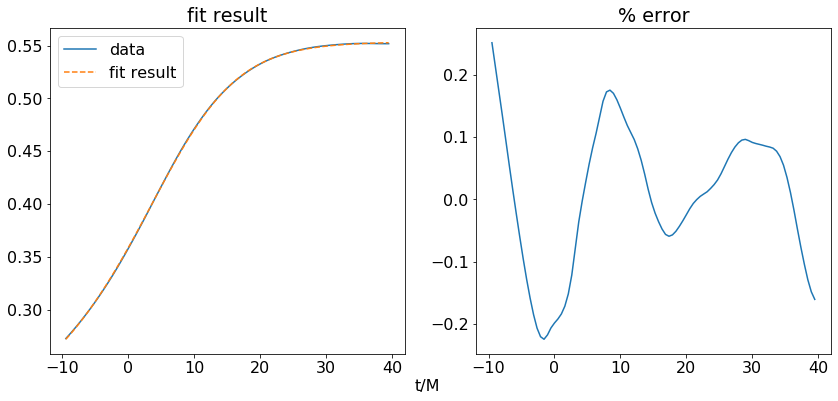

mr bob fit

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 94
    # variables        = 2
    chi-square         = 4.9916e-05
    reduced chi-square = 5.4257e-07
    Akaike info crit   = -1354.15481
    Bayesian info crit = -1349.06822
[[Variables]]
    t0:     -10 (fixed)
    tp:      9.78198405 +/- 0.01574700 (0.16%) (init = 10)
    kappa:   0.25 (fixed)
    b:       11.70642 (fixed)
    om_f:    0.5534662 (fixed)
    offset:  0.26827625 +/- 2.9305e-04 (0.11%) (init = 0.175)
[[Correlations]] (unreported correlations are < 0.100)
    C(tp, offset) =  0.558


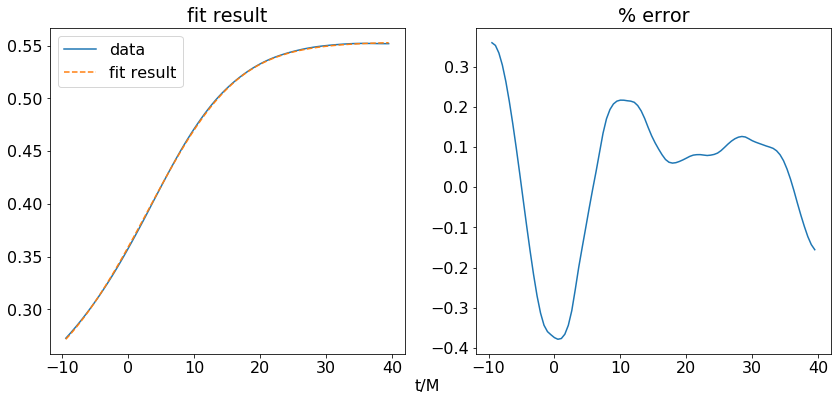

working case: q2
mr fit

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 94
    # variables        = 1
    chi-square         = 7.3645e-05
    reduced chi-square = 7.9188e-07
    Akaike info crit   = -1319.59823
    Bayesian info crit = -1317.05493
[[Variables]]
    t0:      7.94278497 +/- 0.01391953 (0.18%) (init = 5)
    kappa:   0.44 (fixed)
    b:       11.55474 (fixed)
    om_f:    0.5224378 (fixed)
    offset:  0.175 (fixed)


mr bob fit

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 94
    # variables        = 2
    chi-square         = 8.5009e-05
    reduced chi-square = 9.2401e-07
    Akaike info crit   = -1304.10831
    Bayesian info crit = -1299.02172
[[Variables]]
    t0:     -10 (fixed)
    tp:      9.17068896 +/- 0.02254879 (0.25%) (init = 10)
    kappa:   0.25 (fixed)
    b:       11.55474 (fixed)
    om_f:    0.5224378 (fixed)
    offset:  0.26277254 +/- 3.7926e-04 (0.14%) (init = 0.175)
[[Correlations]] (unreported correlations are < 0.100)
    C(tp, offset) =  0.568


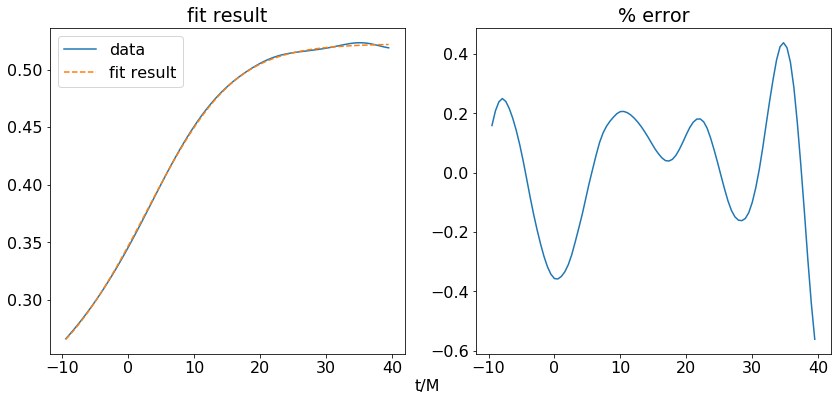

working case: q4
mr fit

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 94
    # variables        = 1
    chi-square         = 8.6384e-05
    reduced chi-square = 9.2886e-07
    Akaike info crit   = -1304.59981
    Bayesian info crit = -1302.05652
[[Variables]]
    t0:      7.27922348 +/- 0.01785496 (0.25%) (init = 5)
    kappa:   0.44 (fixed)
    b:       11.36517 (fixed)
    om_f:    0.4670323 (fixed)
    offset:  0.175 (fixed)


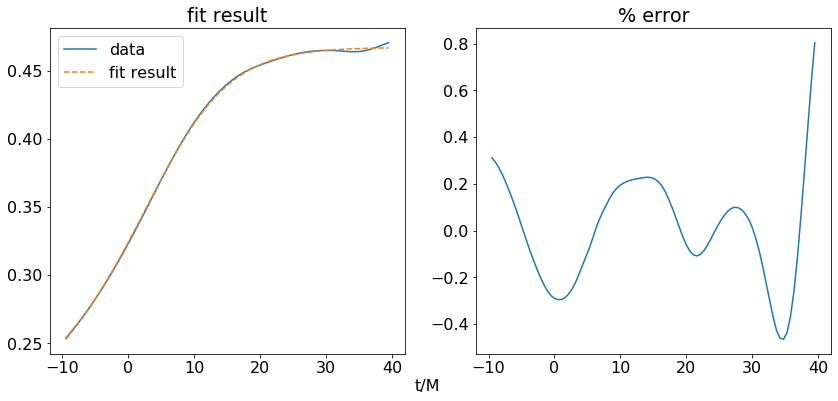

mr bob fit

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 94
    # variables        = 2
    chi-square         = 7.9641e-05
    reduced chi-square = 8.6566e-07
    Akaike info crit   = -1310.24044
    Bayesian info crit = -1305.15385
[[Variables]]
    t0:     -10 (fixed)
    tp:      8.10458671 +/- 0.02649011 (0.33%) (init = 10)
    kappa:   0.25 (fixed)
    b:       11.36517 (fixed)
    om_f:    0.4670323 (fixed)
    offset:  0.25184216 +/- 3.6250e-04 (0.14%) (init = 0.175)
[[Correlations]] (unreported correlations are < 0.100)
    C(tp, offset) =  0.588


working case: q5
mr fit

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 94
    # variables        = 1
    chi-square         = 6.5060e-05
    reduced chi-square = 6.9957e-07
    Akaike info crit   = -1331.24910
    Bayesian info crit = -1328.70581
[[Variables]]
    t0:      7.63604285 +/- 0.01627115 (0.21%) (init = 5)
    kappa:   0.44 (fixed)
    b:       11.32931 (fixed)
    om_f:    0.4515199 (fixed)
    offset:  0.175 (fixed)


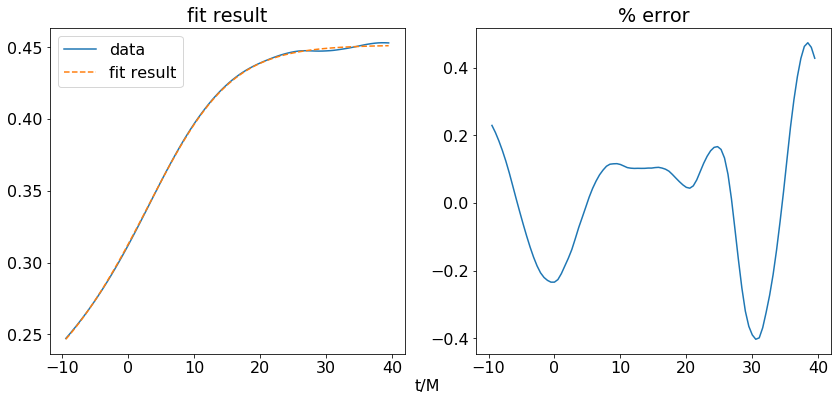

mr bob fit

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 94
    # variables        = 2
    chi-square         = 5.8943e-05
    reduced chi-square = 6.4068e-07
    Akaike info crit   = -1338.53074
    Bayesian info crit = -1333.44415
[[Variables]]
    t0:     -10 (fixed)
    tp:      8.31649713 +/- 0.02364737 (0.28%) (init = 10)
    kappa:   0.25 (fixed)
    b:       11.32931 (fixed)
    om_f:    0.4515199 (fixed)
    offset:  0.24590468 +/- 3.0512e-04 (0.12%) (init = 0.175)
[[Correlations]] (unreported correlations are < 0.100)
    C(tp, offset) =  0.588


working case: q10
mr fit

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 94
    # variables        = 1
    chi-square         = 1.1241e-04
    reduced chi-square = 1.2087e-06
    Akaike info crit   = -1279.84893
    Bayesian info crit = -1277.30563
[[Variables]]
    t0:      7.45278841 +/- 0.02451712 (0.33%) (init = 5)
    kappa:   0.44 (fixed)
    b:       11.27255 (fixed)
    om_f:    0.4158439 (fixed)
    offset:  0.175 (fixed)


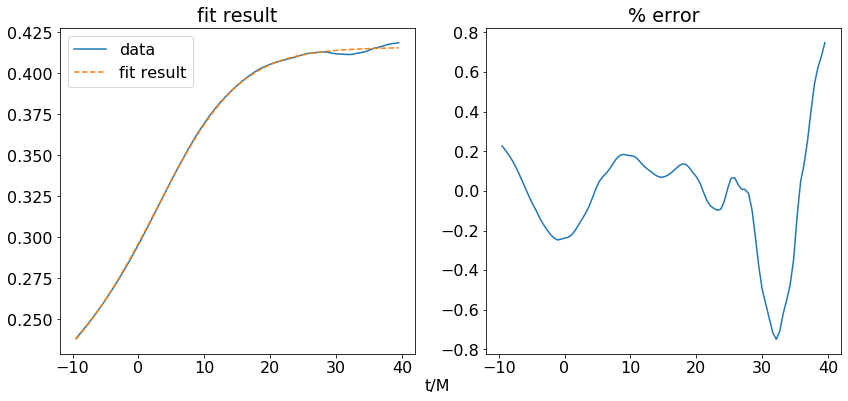

mr bob fit

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 94
    # variables        = 2
    chi-square         = 1.0846e-04
    reduced chi-square = 1.1789e-06
    Akaike info crit   = -1281.21083
    Bayesian info crit = -1276.12424
[[Variables]]
    t0:     -10 (fixed)
    tp:      7.82083345 +/- 0.03724809 (0.48%) (init = 10)
    kappa:   0.25 (fixed)
    b:       11.27255 (fixed)
    om_f:    0.4158439 (fixed)
    offset:  0.23780966 +/- 4.0705e-04 (0.17%) (init = 0.175)
[[Correlations]] (unreported correlations are < 0.100)
    C(tp, offset) =  0.600


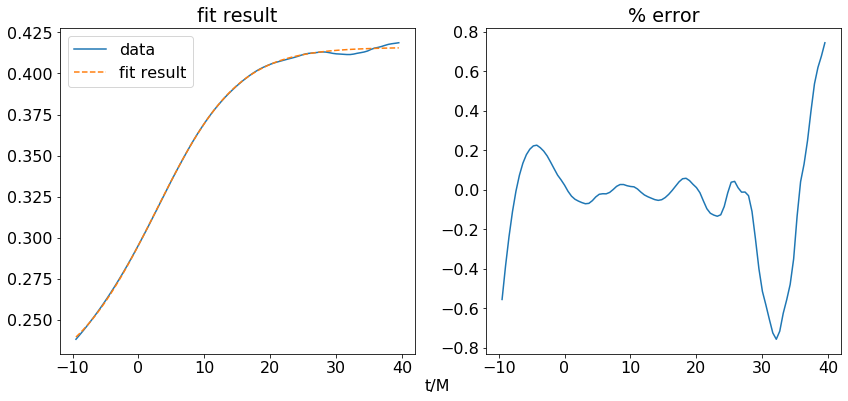

working case: q18
mr fit

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 94
    # variables        = 1
    chi-square         = 7.2484e-04
    reduced chi-square = 7.7940e-06
    Akaike info crit   = -1104.64792
    Bayesian info crit = -1102.10463
[[Variables]]
    t0:      7.61460027 +/- 0.06708314 (0.88%) (init = 5)
    kappa:   0.44 (fixed)
    b:       11.25571 (fixed)
    om_f:    0.397943 (fixed)
    offset:  0.175 (fixed)


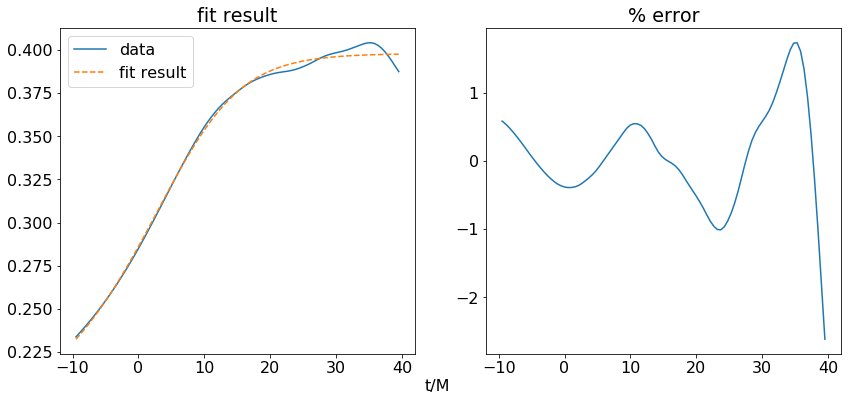

mr bob fit

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 94
    # variables        = 2
    chi-square         = 7.0903e-04
    reduced chi-square = 7.7068e-06
    Akaike info crit   = -1104.72190
    Bayesian info crit = -1099.63531
[[Variables]]
    t0:     -10 (fixed)
    tp:      7.85195403 +/- 0.10270178 (1.31%) (init = 10)
    kappa:   0.25 (fixed)
    b:       11.25571 (fixed)
    om_f:    0.397943 (fixed)
    offset:  0.23334269 +/- 0.00101736 (0.44%) (init = 0.175)
[[Correlations]] (unreported correlations are < 0.100)
    C(tp, offset) =  0.604


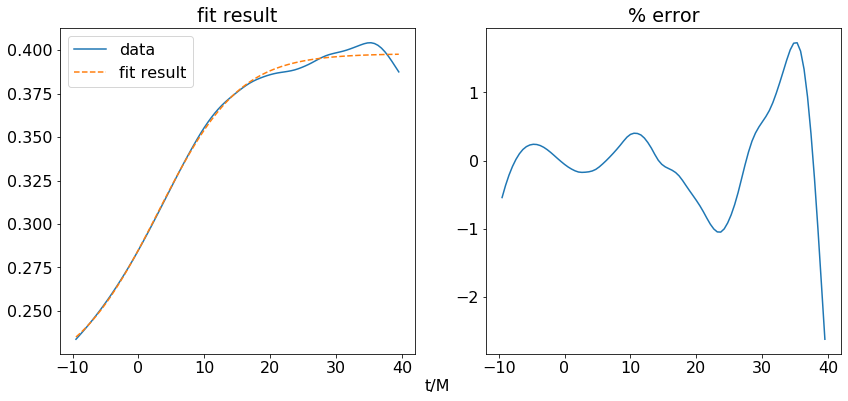

In [172]:
FreqFitDict = {}
for k in psi4s.keys():
    print("working case: {}".format(k))
    FreqFitDict.update({k:FrequencyFit(psi4s[k])})

## freq par space fits

In [173]:
class ParSpaceFits(object):
    def __init__(self, name, FitDict):
        """
        name is a string: {'ins', 'int', 'mr'}
        """
        
        self.name = name
        self.FitDict = FitDict
        
        self.results = {}
        
        for k in self.FitDict.keys():
            
            q = self.FitDict[k].Psi4.q
            eta = self.FitDict[k].Psi4.eta
            self.results.update({k:{"stderr":{}, "fixed":{}, "vary":{}, 'q':q, 'eta':eta}})
            # fit results for 'name'
            fit_region = getattr(self.FitDict[k], self.name)
            
            for pk in fit_region.result.params.keys():
                entry = fit_region.result.params[pk]
                v = entry.value
                vary = entry.vary
                stderr = entry.stderr
                if vary is True:
                    self.results[k]["vary"].update({pk:v})
                    self.results[k]["stderr"].update({pk:stderr})
                else:
                    self.results[k]["fixed"].update({pk:v})
            
        # we can just take the first element because all cases have the same fitting parameters
        k = list(self.FitDict.keys())[0]
        self.vary_parnames = self.results[k]["vary"].keys()
        self.fixed_parnames = self.results[k]["fixed"].keys()
                        
                        
        self.build_arrays()
        
        self.par_space_result = {}
        for k in self.vary_parnames:
            print("working {}\n\n".format(k))
            self.par_space_result.update({k:self.fit(yname=k, xname='eta')})
        
        
    def build_arrays(self):
        
        self.ready_to_fit = {'x':{}, 'y':{}, 'stderr':{}}
        
        parnames = self.results[list(self.results.keys())[0]]['vary']
        
        for parname in parnames:
            array_eta = []
            array_q = []
            array_y = []
            array_stderr = []
            for k in self.results.keys():
                array_eta.append(self.results[k]['eta'])
                array_q.append(self.results[k]['q'])
                array_y.append(self.results[k]['vary'][parname])
                array_stderr.append(self.results[k]['stderr'][parname])
            

            self.ready_to_fit['x'].update({"eta":np.array(array_eta), "q":np.array(array_q)})
            self.ready_to_fit['y'].update({parname:np.array(array_y)})
            self.ready_to_fit['stderr'].update({parname:np.array(array_stderr)})
            
    def model_evaluate(self, parname, x):
        params = self.par_space_result[parname].params
        return self.ansatz(params, x)
            
    def ansatz(self, params, x):

        a = params['a']
        b = params['b']
        c = params['c']
        d = params['d']
        e = params['e']
#         f = params['f']

#         model = a + b*x + c*np.sqrt(x)
#         model = a + b*x + c*np.log(x)
#         model = a + b*x + c*x**2
#         model = a + b*x + c*x**2 + d*x**3
#         model = a + b*x + d*x**3
        model = a + b*x + c*x**2 + d*x**3 + e*x**4
#         model = a + b*x + c*x**2 + d*x**3 + e*x**4 + f*x**5

        return model

    def ansatz_to_min(self, params, x, y):
        model = self.ansatz(params, x)
        return model - y

    def fit(self, yname, xname='eta'):
        
        
        fit_x = self.ready_to_fit['x'][xname]
        fit_y = self.ready_to_fit['y'][yname]
    
    
        # sort them by first column i.e. mass-raito or eta
        fit_xy = np.array([fit_x, fit_y]).T
        tmp = sorted(fit_xy, key=lambda x: x[0])
        tmp = np.array(tmp).T
        self.fit_x, self.fit_y = tmp[0], tmp[1]

        # create a set of Parameters
        params = Parameters()

        params.add('a', value=10., min=-50000, max=50000)
        params.add('b', value=300., min=-40000, max=50000)
        params.add('c', value=400., min=-40000, max=40000)
        params.add('d', value=300., min=-70000, max=70000)
        params.add('e', value=300., min=-70000, max=70000)
#         params.add('f', value=300., min=-40000, max=40000)

        fcn2min = self.ansatz_to_min
        minner = Minimizer(fcn2min, params, fcn_args=(self.fit_x, self.fit_y))

        result = minner.minimize()

        # calculate final result
        final = self.fit_y + result.residual

        # write error report
        report_fit(result)
        return result


In [174]:
PSF_freq_mr=ParSpaceFits("mr", FreqFitDict)

PSF_freq_mr_bob=ParSpaceFits("mr_bob", FreqFitDict)

working t0


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 18
    # data points      = 6
    # variables        = 5
    chi-square         = 0.07870146
    reduced chi-square = 0.07870146
    Akaike info crit   = -16.0031185
    Bayesian info crit = -17.0443212
[[Variables]]
    a:  7.84066604 +/- 3.16990442 (40.43%) (init = 10)
    b: -7.06870188 +/- 109.978917 (1555.86%) (init = 300)
    c:  59.0526210 +/- 1269.64751 (2150.03%) (init = 400)
    d: -354.591130 +/- 6002.54241 (1692.81%) (init = 300)
    e:  1063.58564 +/- 9985.25323 (938.83%) (init = 300)
[[Correlations]] (unreported correlations are < 0.100)
    C(d, e) = -0.994
    C(c, d) = -0.992
    C(b, c) = -0.991
    C(a, b) = -0.989
    C(c, e) =  0.973
    C(b, d) =  0.967
    C(a, c) =  0.963
    C(b, e) = -0.935
    C(a, d) = -0.926
    C(a, e) =  0.885
working tp


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 18
    # data points      = 6
    # variables       

In [175]:
print(PSF_freq_mr.results['q1']['vary'].keys())
print(PSF_freq_mr_bob.results['q1']['vary'].keys())

dict_keys(['t0'])
dict_keys(['tp', 'offset'])


In [176]:
print(PSF_freq_mr.results['q1']['fixed'].keys())
print(PSF_freq_mr_bob.results['q1']['fixed'].keys())

dict_keys(['kappa', 'b', 'om_f', 'offset'])
dict_keys(['t0', 'kappa', 'b', 'om_f'])


plots for mr


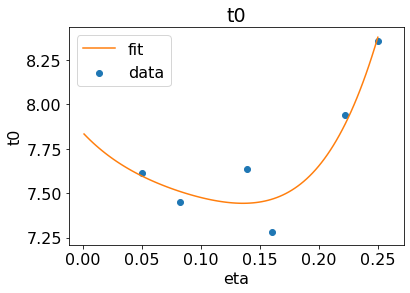

plots for mr_bob


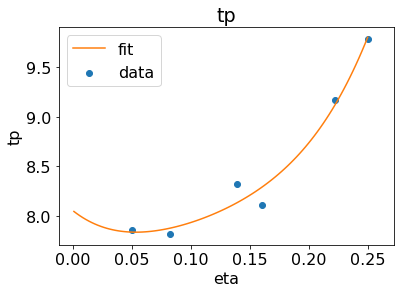

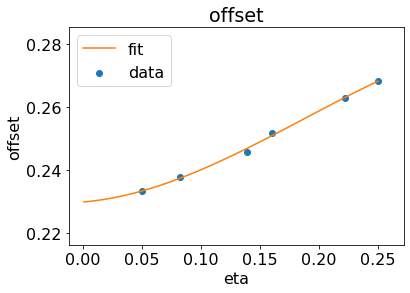

In [177]:
parts = [PSF_freq_mr, PSF_freq_mr_bob]
for part in parts:
    print("plots for {}".format(part.name))

    xs = np.linspace(0.001,0.25,100)

    for y in part.vary_parnames:
        plt.figure()
        plt.scatter(part.ready_to_fit['x']['eta'], part.ready_to_fit['y'][y], label='data')
        plt.plot(xs, part.model_evaluate(y, xs), c='C1', label='fit')
        plt.xlabel('eta')
        plt.legend()
        plt.ylabel(y)
        plt.title(y)
        plt.show()
        plt.close()

## GPR fit of freq coefficients

In [179]:
freq_parts = [PSF_freq_mr, PSF_freq_mr_bob]


for part in freq_parts:
    # Serialize data into file:
    data = part.ready_to_fit
    part_name = part.name
    name = "freq_{}.p".format(part_name)
    pickle.dump(data, open(name, "wb"))

import glob
files = glob.glob("freq_*.p")
freq_coeffs_to_fit = {}
for f in files:
    freq_coeffs_to_fit.update({f.split('.p')[0]:pickle.load(open(f, 'rb'))})

In [181]:
freq_coeffs_to_fit['freq_mr_bob']

{'x': {'eta': array([0.25      , 0.22222234, 0.1600003 , 0.13888911, 0.08264502,
         0.04986614]), 'q': array([ 1.,  2.,  4.,  5., 10., 18.])},
 'y': {'tp': array([9.78198405, 9.17068896, 8.10458671, 8.31649713, 7.82083345,
         7.85195403]),
  'offset': array([0.26827625, 0.26277254, 0.25184216, 0.24590468, 0.23780966,
         0.23334269])},
 'stderr': {'tp': array([0.015747  , 0.02254879, 0.02649011, 0.02364737, 0.03724809,
         0.10270178]),
  'offset': array([0.00029305, 0.00037926, 0.0003625 , 0.00030512, 0.00040705,
         0.00101736])}}

In [182]:
np.random.seed(1)
def fit_and_plot_gpr(name, data, PSF=None):
    """
    name = ['amp_mr']
    data = e.g data dict
    PSF = parameter space fits 
    """
    data = data[name]
    PSF = PSF[name]
    
    ys = list(data['y'].keys())
    
    for yname in ys:
        
        X = data['x']['eta'].reshape((6,1))
        y = data['y'][yname]
        
        dy = data['stderr'][yname]
        
        # Instantiate a Gaussian Process model
        kernel = C(1.0, (1e-4, 1e4)) * RBF(10, (1e-4, 1e4))


#         gp = GaussianProcessRegressor(kernel=kernel,
#                                       n_restarts_optimizer=100,
#                                       normalize_y=True
#                                      )

#         gp = GaussianProcessRegressor(kernel=kernel,
#                                       n_restarts_optimizer=100,
#                                       normalize_y=True
#                                      )

#         gp = GaussianProcessRegressor(kernel=kernel,
#                                       n_restarts_optimizer=100,
#                                       alpha=dy**2, normalize_y=True
#                                      )
        gp = GaussianProcessRegressor(kernel=kernel,
                                      n_restarts_optimizer=100,
                                      alpha=dy**2, normalize_y=False
                                     )

        # Fit to data using Maximum Likelihood Estimation of the parameters
        gp.fit(X, y)

        x = np.linspace(0,0.25,100).reshape((100,1))

        # Make the prediction on the meshed x-axis (ask for MSE as well)
        y_pred, sigma = gp.predict(x, return_std=True)
        
        # Plot the function, the prediction and the 95% confidence interval based on
        # the MSE
        plt.figure(figsize=(10,6))
#         plt.plot(X, y, 'r.', markersize=10, label='Observations')
        plt.plot(x, y_pred, 'b-', label='Prediction')
        plt.fill(np.concatenate([x, x[::-1]]),
                 np.concatenate([y_pred - 1.9600 * sigma,
                                (y_pred + 1.9600 * sigma)[::-1]]),
                 alpha=.5, fc='b', ec='None', label='95% confidence interval')
        plt.xlabel('$\eta$')
        plt.ylabel('{}'.format(yname))
        # plt.ylim(-10, 20)
        
        plt.errorbar(X.ravel(), y, dy, fmt='r.', markersize=10, label='Observations')
        
        if PSF:
            PSFy = PSF.model_evaluate(yname, x)
            plt.plot(x, PSFy, label='polynomial', lw=3, ls='--')
        
        plt.legend(loc='best')
        plt.show()
        plt.close()
        
        print("gp kernel params")
        print(gp.kernel_.get_params())
        
        

        outname = "{}-{}.pkl".format(name, yname)
        print("saving gp model to: {}".format(outname))
        with open(outname,'wb') as f:
            pickle.dump(gp,f)

====

working: freq_mr

====



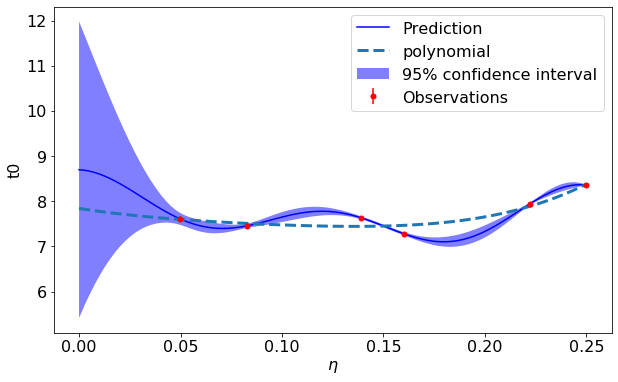

gp kernel params
{'k1': 6.2**2, 'k2': RBF(length_scale=0.0716), 'k1__constant_value': 38.39946412898749, 'k1__constant_value_bounds': (0.0001, 10000.0), 'k2__length_scale': 0.07163137707281542, 'k2__length_scale_bounds': (0.0001, 10000.0)}
saving gp model to: freq_mr-t0.pkl
====

working: freq_mr_bob

====



gp kernel params
{'k1': 6.83**2, 'k2': RBF(length_scale=0.0743), 'k1__constant_value': 46.64604484486519, 'k1__constant_value_bounds': (0.0001, 10000.0), 'k2__length_scale': 0.07426595396717499, 'k2__length_scale_bounds': (0.0001, 10000.0)}
saving gp model to: freq_mr_bob-tp.pkl


/Users/spx8sk/anaconda3/envs/wispy-dev/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 5.94208905e-06, -1.04140603e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)


gp kernel params
{'k1': 0.297**2, 'k2': RBF(length_scale=0.984), 'k1__constant_value': 0.08814713602188287, 'k1__constant_value_bounds': (0.0001, 10000.0), 'k2__length_scale': 0.9837963857371838, 'k2__length_scale_bounds': (0.0001, 10000.0)}
saving gp model to: freq_mr_bob-offset.pkl


In [184]:

PSFs = dict(freq_mr=PSF_freq_mr, freq_mr_bob=PSF_freq_mr_bob)
for k in freq_coeffs_to_fit.keys():
    print("====\n")
    print("working: {}".format(k))
    print("\n====\n")

    fit_and_plot_gpr(k, freq_coeffs_to_fit, PSFs)